# Data extraction and processing
see here for API tutorial on selecting data
http://docs.synapse.org/rest/org/sagebionetworks/repo/web/controller/TableExamples.html

In [2]:
# # %load sc2FitModels.py

In [942]:
import pandas as pd
import json
import numpy as np
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [943]:
from IPython.core.debugger import Tracer

In [944]:
import synapseclient

In [5]:
syn=synapseclient.login()

Welcome, Nicholas Shawen!



### Helper fcns - Feature extraction and clip generation

In [945]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
#     sH_raw = []; sH_fft = []
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list


def gen_clips(rawdata,clipsize=5,overlap=0):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used (deprecated for now)
    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if len(c) > 10: #at least n data points in clip
            clips.append(c)
#         if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
    return clips

#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin; #if nbins = -1 does not bin the data
#if binavg is True it averages the PSD within bins to reduce PSD noise
#**DO NOT USE - NEED TO FIX BUG*** 
def powerspectra(x,fm,fM,nbins=-1,relative=False,binavg=True):
    
    #feature labels (if binned)
    labels=[]
    if nbins > 0:
        s = np.linspace(fm,fM,nbins)
        lax = ['X','Y','Z']
        for l in lax:
            for i in s:
                labels.append('fft'+l+str(int(i)))
        
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.nanmean(1/(np.diff(x.timestamp))) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    x = x.drop('timestamp',axis=1)
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
        
    if nbins > 0:
        #power spectra between fm-fM Hz
        bin1 = int(timestep*n*fm)
        bin2 = int(timestep*n*fM)
        bins = np.linspace(bin1,bin2,nbins,dtype=int)
    #     print(bins/(round(timestep*n)))

        #average power spectra within bins - CHECK FOR BUG!
        if binavg:
            deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
            Pxxm = []
            for i in bins:
                start = int(max(i-deltab,bins[0]))
                end = int(min(i+deltab,bins[-1]))
                Pxxm.append(np.nanmean(Pxx.iloc[start:end,:].values,axis=0))            
            Pxxm = np.asarray(Pxxm)
            Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
            return Pxx, labels

        else:
            return Pxx.iloc[bins,:], labels
    #no binning
    else:
        return Pxx

    
#PSD on magnitude using Welch
def power_spectra_welch(rawdata,fm,fM):
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf

    
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt


In [946]:
#X,y are numpy arrays with features and target
#returns mean feature importance
def LOSOCV(X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
            else:
                print('no positive examples for current test subj')
                Sens = np.nan
            if np.sum(yte==0)>0:
                Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
            else:
                Spec = np.nan
                print('no negative examples for current test subj')
            Sens_all.append(Sens); Spec_all.append(Spec)
            #compute accuracy
            acc = sum(ypred==yte)/len(yte)
            acc_all.append(acc)
            #save fimp
            fi_all.append(clf.feature_importances_)
        
        #mean across all subjects
        print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
        print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
        print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
        print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))

    return fi_all

In [7]:
syntable = syn.tableQuery("SELECT * from syn10495809")

In [5]:
table = syntable.asDataFrame()

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5168 entries, 25819_22 to 30986_23
Data columns (total 11 columns):
dataFileHandleId     5168 non-null int64
device               5168 non-null object
patient              5168 non-null object
session              5168 non-null int64
site                 5168 non-null object
task                 5168 non-null object
visit                5168 non-null int64
deviceSide           5168 non-null object
tremorScore          3667 non-null float64
dyskinesiaScore      1556 non-null float64
bradykinesiaScore    3016 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 484.5+ KB


In [7]:
table.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN


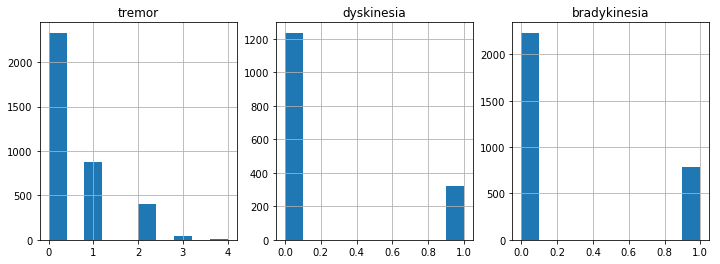

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
plt.title('tremor')
table.tremorScore.hist()
ax = fig.add_subplot(132)
table.dyskinesiaScore.hist()
plt.title('dyskinesia')
ax = fig.add_subplot(133)
table.bradykinesiaScore.hist()
plt.title('bradykinesia')

In [9]:
table.task.unique()

array(['drnkg', 'fldng', 'ftnl1', 'ftnl2', 'ftnr1', 'ftnr2', 'ntblt',
       'orgpa', 'raml1', 'raml2', 'ramr1', 'ramr2'], dtype=object)

In [10]:
sum(table.tremorScore==4)

12

# Bradykinesia

In [947]:
q_brady_train = syn.tableQuery("SELECT * from syn10495809 where bradykinesiaScore is not null")

In [948]:
paths_train = syn.downloadTableColumns(q_brady_train,'dataFileHandleId')

In [949]:
df_train = q_brady_train.asDataFrame()

In [950]:
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [952]:
df_train.head(5)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/nicholasshawen/.synapseCache/28/1728602...
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/nicholasshawen/.synapseCache/30/1728603...
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/nicholasshawen/.synapseCache/34/1728603...
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/nicholasshawen/.synapseCache/36/1728603...
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/nicholasshawen/.synapseCache/42/1728604...


In [951]:
df_train_brady = df_train

## Train a baseline classifier using the metadata only

In [13]:
len(df_train.patient.unique())

19

In [14]:
X_meta = df_train[['dataFileHandleId','device','patient','session','site','task','visit','deviceSide']]
y_meta = df_train['bradykinesiaScore']

## Encode categorical variables with dummy values

In [954]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [16]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left


In [17]:
X_meta_copy = X_meta.copy()
cat_cols = X_meta.select_dtypes(['object']).columns
for c in cat_cols:
    X_meta_copy[c]=le.fit_transform(X_meta[c])

In [18]:
X_meta_copy.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,0,2,1,0,0,1,1
25820_22,17286030,1,2,1,0,0,1,0
25821_22,17286034,0,2,1,0,1,1,1
25822_22,17286036,1,2,1,0,1,1,0
25824_22,17286042,1,2,1,0,2,1,0


In [19]:
X_meta=X_meta_copy

# Make dummy submission file to test score fcn

In [28]:
X_meta.to_csv('DummySubmission.csv',index=False)

In [29]:
%run sc2FitModels.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: 0.9898671060750107


## Explore data

dataFileHandleId                                              17286072
device                                                          Pebble
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             orgpa
visit                                                                1
deviceSide                                                        Left
tremorScore                                                          1
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/72/17286072...
Name: 25834_22, dtype: object


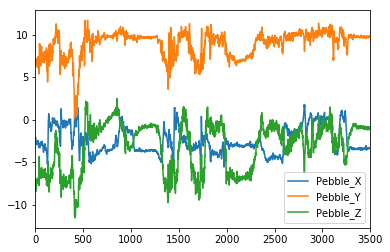

In [18]:
#plot task
idx=9
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata.iloc[:,1:4].plot()

In [577]:
#durations of tasks
c = 0
Dur = []
for f in df_train.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)

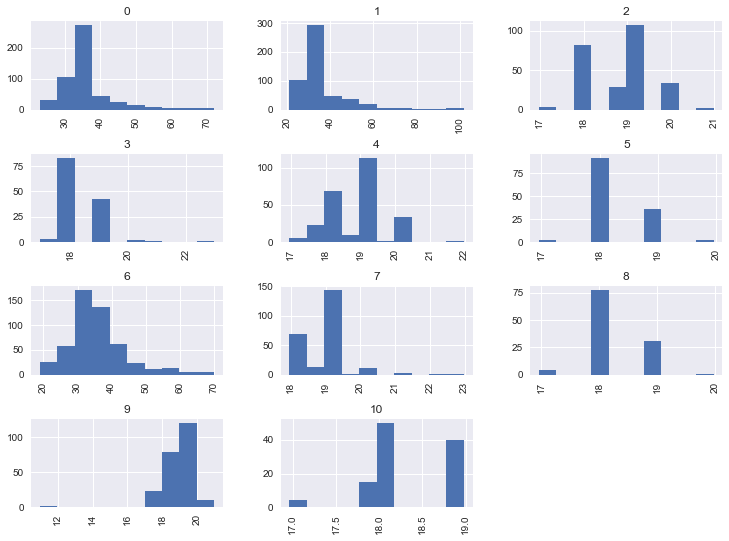

In [578]:
plt.figure(figsize=(12,4))
df_train['Duration']=Dur
ax = df_train.hist(column='Duration',by='task',figsize=(12,9))

In [22]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...,38.98
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...,38.98
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...,101.98
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...,101.98
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...,17.98


In [124]:
# #display duration based on presence of bradykinesia
# for t in df_train.task.unique():
#     fig = plt.figure()
#     for i in range(2):
#         d = df_train[(df_train['bradykinesiaScore']==i) & (df_train['task']==t)]
#         if ~d.empty:
#             try:
#                 sns.distplot(d['Duration'])
#             except(ZeroDivisionError):
#                 print(d.empty)
#     plt.title(t)

## Try Metadata features + Duration feature

In [24]:
X_meta['Duration']=df_train['Duration']

In [25]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,2,1,0,0,1,1,38.98
25820_22,17286030,1,2,1,0,0,1,0,38.98
25821_22,17286034,0,2,1,0,1,1,1,101.98
25822_22,17286036,1,2,1,0,1,1,0,101.98
25824_22,17286042,1,2,1,0,2,1,0,17.98


In [963]:
X = X_meta
scaler = StandardScaler()
X.iloc[:,-1]=scaler.fit_transform(X.iloc[:,8:])

In [965]:
X.to_csv('Meta_wDur.csv',index=False)

In [966]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Meta_wDur.csv

Welcome, Luca Lonini!

AUPRC: [0.94398336312474074, 0.1478882617202292, 0.94182279342107333, 0.96200299957554858, 0.77537483776358485, 0.99019019019019017, 0.99118165784832446, 0.9531456387497157, 0.41141654065110317, 0.98894009216589862, 0.34097351815805521, 0.4423668371328594, 0.18253298531557141, 0.90168575227823167, 0.75958758503401358, 0.4158965898076592, 0.95355067798597348, 0.28619378306878307, 0.98987841405218802]


In [840]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: [0.96418540805444453, 0.14027760685472601, 0.93497830075740962, 0.95911290159512474, 0.88405791313831983, 0.99019019019019017, 0.99118165784832446, 0.95310487912775166, 0.53794863427354733, 0.98894009216589862, 0.3443364414391421, 0.43842766253874399, 0.20572814485384885, 0.90425993036445451, 0.81553996598639455, 0.48223919859596359, 0.97285450032294607, 0.23109434865900383, 0.98636489479512734]


In [964]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,2,1,0,0,1,1,1.042534
25820_22,17286030,1,2,1,0,0,1,0,1.042534
25821_22,17286034,0,2,1,0,1,1,1,6.784089
25822_22,17286036,1,2,1,0,1,1,0,6.784089
25824_22,17286042,1,2,1,0,2,1,0,-0.871318


## Clips generation and feature extraction

### Test fcns

dataFileHandleId                                              17286084
device                                                          Pebble
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             raml2
visit                                                                1
deviceSide                                                        Left
tremorScore                                                          2
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/84/17286084...
Duration                                                         18.98
Name: 25838_22, dtype: object


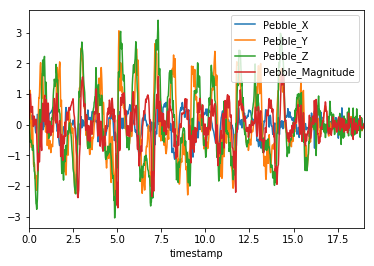

In [60]:
#plot task
idx=11
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata = filter_signal(rawdata,order=2)
ax = rawdata.plot(x='timestamp')

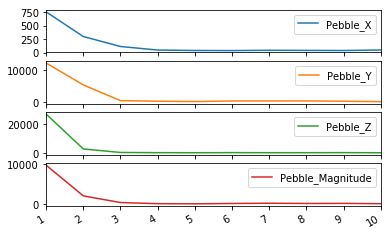

In [61]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=10)
ax = Pxx.plot(subplots=True)

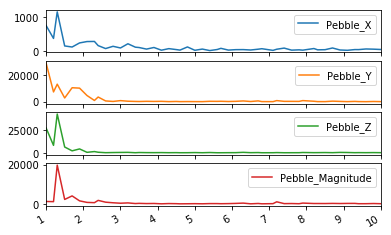

In [62]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=50)
ax = Pxx.plot(subplots=True)

In [26]:
domfreq = np.asarray([Pxx.iloc[:,-1].argmax()])
domfreq

array([ 1.3])

In [27]:
Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum()

array([ 0.47673788])

## Compute features on all rows and time it

#### Test on 1 row

In [187]:
F,flist = feature_extraction(rawdata)

In [188]:
F.shape

(1, 26)

In [458]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 58.6
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


In [304]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(3016, 26)


## Compute features on windows and take stats over windows

In [692]:
row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,overlap=0) #take clips
            for clip in clips:
                F,flist = feature_extraction(clip)
                Fclips.append(F) #the features from all the clips
            #stack mean and std over clips
            flist = flist+['s_'+n for n in flist] #update feature list w std
            Fmean = np.mean(Fclips,axis=0)
            Fstd = np.std(Fclips,axis=0)
            F = np.hstack((Fmean,Fstd))
            if F.size != 52:
                print(F.shape)
                sys.exit()
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
            
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 134.1
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


(array([ 44.,   8.,   7.,   5.,   4.,   2.,   2.,   5.,   7.,   3.]),
 array([  4.87804878e-04,   9.77467167e-02,   1.95005629e-01,
          2.92264540e-01,   3.89523452e-01,   4.86782364e-01,
          5.84041276e-01,   6.81300188e-01,   7.78559099e-01,
          8.75818011e-01,   9.73076923e-01]),
 <a list of 10 Patch objects>)

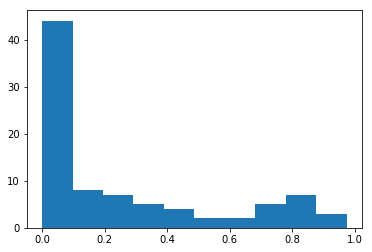

In [630]:
plt.hist(np.asarray(max_nans))

In [299]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

ValueError: could not broadcast input array from shape (26) into shape (1)

### append feature to df_train

In [305]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [306]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25819_22,17286028,0,13_BOS,0,0,0,0,1,1,NaN,...,5.618544,55.162070,3.331870,1.405428,17.940271,0.508,0.548,0.428,9.8,0.084778
25820_22,17286030,1,13_BOS,0,0,0,0,0,1,NaN,...,2.378925,6.159189,0.254936,0.850625,0.386937,0.060,0.648,0.472,1.2,0.494207
25821_22,17286034,0,13_BOS,0,0,1,0,1,2,NaN,...,3.268669,1.204823,1.083183,1.118650,0.577063,0.684,0.836,0.452,9.0,0.085588
25822_22,17286036,1,13_BOS,0,0,1,0,0,1,NaN,...,0.314374,-0.471802,0.232712,0.801341,0.717468,0.940,0.310,0.510,2.5,0.384501
25824_22,17286042,1,13_BOS,0,0,2,0,0,2,NaN,...,0.263820,-0.154934,0.199098,0.443844,0.399473,0.368,0.392,0.580,1.6,0.404046


### Test performance

In [307]:
X = pd.concat((X_meta,df_train.iloc[:,13:]),axis=1)

NameError: name 'X_meta' is not defined

In [308]:
X['bradykinesiaScore']=df_train['bradykinesiaScore']

NameError: name 'X' is not defined

In [701]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,s_kurtZ,s_xcor_peakXY,s_xcorr_peakXZ,s_xcorr_peakYZ,s_xcorr_lagXY,s_xcorr_lagXZ,s_xcorr_lagYZ,s_Dom_freq,s_Pdom_rel,bradykinesiaScore
25819_22,17286028,0,2,1,0,0,1,1,32.743096,8.294654,...,20.048757,6.220360,3.633610,5.631900,0.146203,0.164618,0.166045,1.857743,0.032124,1
25820_22,17286030,1,2,1,0,0,1,0,142.506737,259.988610,...,1.637227,1.072114,6.525817,33.721069,0.207634,0.165770,0.063750,0.606701,0.116089,1
25821_22,17286034,0,2,1,0,1,1,1,129.048050,104.939176,...,2.380954,9.405408,1.620735,5.773385,0.154786,0.131271,0.156614,2.731325,0.033724,1
25822_22,17286036,1,2,1,0,1,1,0,113.334655,117.228067,...,1.659374,1.449201,4.550834,1.551287,0.186340,0.172658,0.084203,0.571667,0.066273,1
25824_22,17286042,1,2,1,0,2,1,0,84.982941,153.201798,...,0.450623,0.445990,0.695895,0.705364,0.052412,0.017292,0.112824,0.086603,0.062471,1


In [702]:
X.shape

(3016, 61)

In [703]:
X.columns

Index(['dataFileHandleId', 'device', 'patient', 'session', 'site', 'task',
       'visit', 'deviceSide', 'EX', 'EY', 'EZ', 'rangeX', 'rangeY', 'rangeZ',
       'meanX', 'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY',
       'skewZ', 'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
       'Pdom_rel', 's_EX', 's_EY', 's_EZ', 's_rangeX', 's_rangeY', 's_rangeZ',
       's_meanX', 's_meanY', 's_meanZ', 's_varX', 's_varY', 's_varZ',
       's_skewX', 's_skewY', 's_skewZ', 's_kurtX', 's_kurtY', 's_kurtZ',
       's_xcor_peakXY', 's_xcorr_peakXZ', 's_xcorr_peakYZ', 's_xcorr_lagXY',
       's_xcorr_lagXZ', 's_xcorr_lagYZ', 's_Dom_freq', 's_Pdom_rel',
       'bradykinesiaScore'],
      dtype='object')

In [704]:
X=X.dropna()

In [705]:
#drop target col
y = X['bradykinesiaScore'].values
X = X.drop('bradykinesiaScore',axis=1)

** Standardize features **

In [706]:
#standardize features
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [707]:
X.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,s_kurtY,s_kurtZ,s_xcor_peakXY,s_xcorr_peakXZ,s_xcorr_peakYZ,s_xcorr_lagXY,s_xcorr_lagXZ,s_xcorr_lagYZ,s_Dom_freq,s_Pdom_rel
25819_22,17286028,0,2,1,0,0,1,1,-0.413492,-0.492503,...,-0.051645,2.568390,-0.025605,-0.084616,-0.027269,0.631907,0.986645,1.033993,0.746156,-0.736288
25820_22,17286030,1,2,1,0,0,1,0,-0.386449,-0.402976,...,-0.211256,-0.269512,-0.076323,-0.011616,0.279385,1.541076,1.004108,-0.512818,-0.653833,1.925762


In [708]:
#Save a copy for later use
X_copy = X.copy()

## Check feature importance with XGBoost classifier

In [709]:
#LOSO CV
groups = X.patient.as_matrix()

In [710]:
models = [XGBClassifier()]
model_name = ['XGB']
models = list(zip(models,model_name))

In [711]:
X = X.drop('patient',axis=1)

In [712]:
fimp_all = LOSOCV(X.iloc[:,1:].as_matrix(),y,groups,models)

Training XGB
XGB, mean Acc on training set = 0.945 (+/- 0.002)
XGB, mean Sens = 0.535 (+/- 0.180)
XGB, mean Spec = 0.973 (+/- 0.024)
XGB, mean Acc = 0.896 (+/- 0.047)


In [713]:
fimp_all=np.asarray(fimp_all)

In [714]:
fimp_mean=np.mean(fimp_all,axis=0)

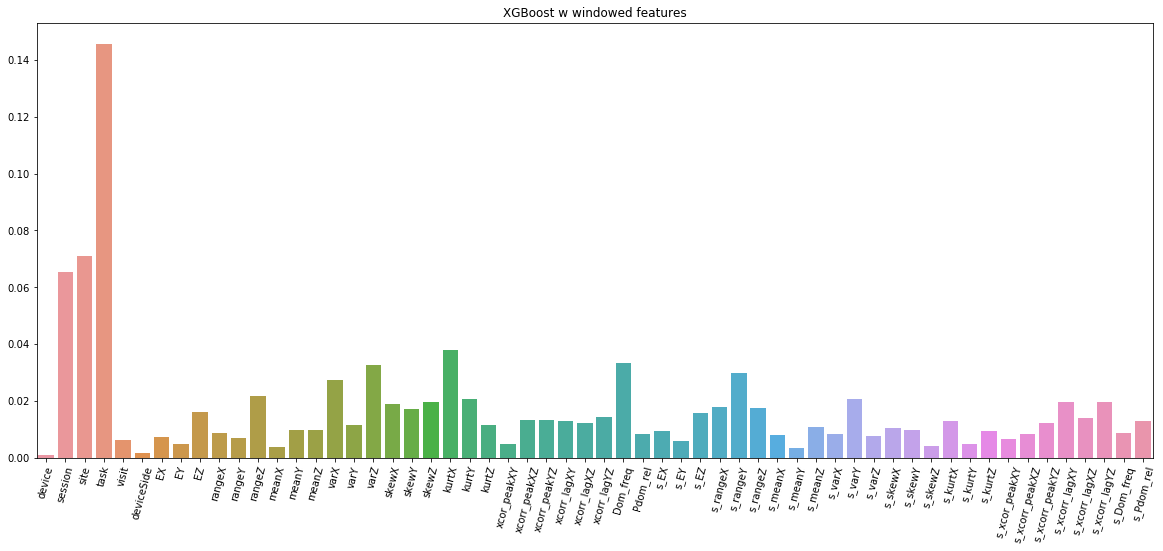

In [715]:
clf = models[0][0]
fimp = pd.Series(index=X.columns[1:],data=fimp_mean)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost w windowed features')

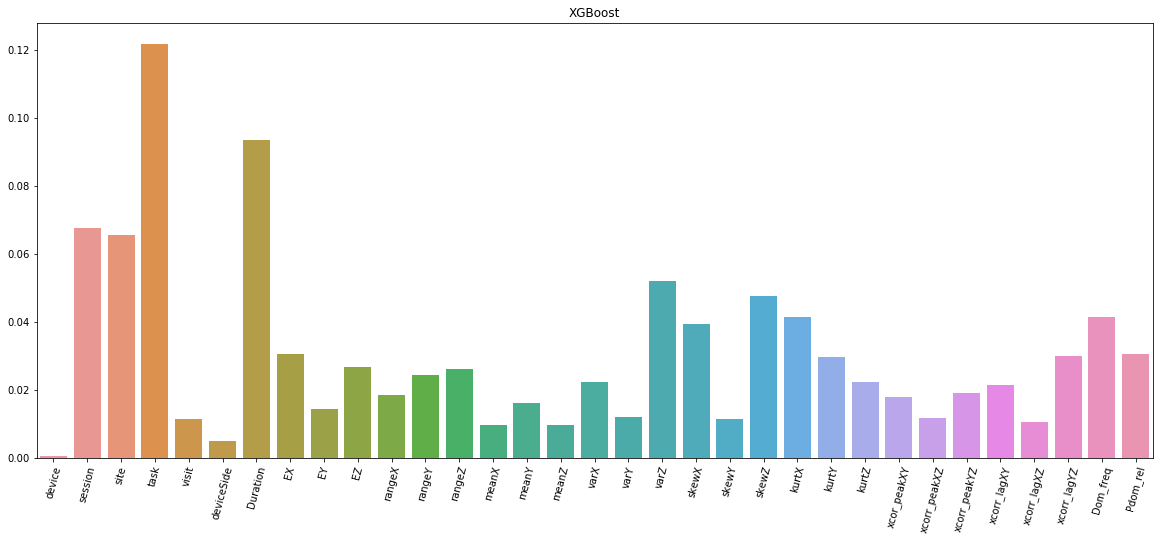

In [169]:
clf = models[0][0]
fimp = pd.Series(index=X.columns[1:],data=fimp_mean)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost')

## Submission

In [717]:
X = X_copy

In [718]:
X.to_csv('Submission_winFeat.csv',index=False)

In [722]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_basicFeat.csv #feat on entire recording

Welcome, Luca Lonini!

AUPRC: 0.891


In [723]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_winFeat.csv

Welcome, Luca Lonini!

AUPRC: 0.868


In [721]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Meta_wDur.csv

Welcome, Luca Lonini!

AUPRC: 0.823


In [716]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: 0.814


In [875]:
coldrop=list(X.columns)[1:8]
coldrop.remove('patient')

In [877]:
X_featonly=X.drop(coldrop,axis=1)

In [878]:
X_featonly.to_csv('Featonly.csv',index=False)

In [879]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Featonly.csv

Welcome, Luca Lonini!

AUPRC: [0.92813597493628708, 0.10489913015856153, 0.93836956015802164, 0.95887173606110998, 0.79884693703799836, 0.95417932750479961, 0.87578096294956786, 0.51731107929267139, 0.16323291374897519, 0.89098782593317161, 0.1532074956641859, 0.19316931567203727, 0.093671750656162539, 0.81906306768680603, 0.060397277662888209, 0.35731165553082878, 0.96290579105755925, 0.01161578417073357, 0.97793564316195969]


** Feature computation time on 1 clip **

In [323]:
t1 = time.time()
rawdata = pd.read_csv(f,sep='\t')
print(time.time()-t1)
t1 = time.time()
F,flist = feature_extraction(rawdata)
print(time.time()-t1)


0.003940105438232422
0.009171009063720703


# Dyskinesia

In [9]:
q_dysk_train = syn.tableQuery("SELECT * from syn10495809 where dyskinesiaScore is not null")
paths_train = syn.downloadTableColumns(q_dysk_train,'dataFileHandleId')

In [10]:
df_train_dysk = q_dysk_train.asDataFrame()

In [11]:
df_train_dysk['path']=df_train_dysk.dataFileHandleId.astype(str).map(paths_train)

In [12]:
df_train_dysk.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/39/17286039...
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/45/17286045...


In [886]:
df_train = df_train_dysk

In [887]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)

0


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


1000
Elapsed Time:[s] 38.7
Files w nans: 88
Files w 0 non-nan rows 56


In [891]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(1556, 26)


In [893]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [894]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,...,0.162701,-0.079857,4.745927,0.734146,0.546572,0.506667,0.503333,0.497778,8.1,0.072784
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,...,0.134648,-0.026859,1.458933,1.109415,41.765466,0.515556,0.503333,0.496667,6.1,0.058848
25828_22,17286054,Pebble,13_BOS,1,Boston,ftnr1,1,Left,NaN,0,...,7.689771,1.385359,0.359814,0.669308,0.856794,0.505556,0.543333,0.485556,1.3,0.083133
25830_22,17286060,Pebble,13_BOS,1,Boston,ftnr2,1,Left,NaN,0,...,11.841003,3.249798,2.058724,1.980309,0.381623,0.498947,0.521053,0.500000,1.0,0.145483
25835_22,17286076,GENEActiv,13_BOS,1,Boston,raml1,1,Right,NaN,0,...,0.566197,0.002158,1.541055,2.828754,31.930616,0.482105,0.549474,0.557895,5.7,0.515168


In [911]:
X = df_train.copy()
cat_cols = df_train.select_dtypes(['object']).columns
for c in cat_cols:
    X[c]=le.fit_transform(df_train[c])

In [913]:
#drop scores cols
X = X.drop(['tremorScore','dyskinesiaScore','bradykinesiaScore','path'],axis=1)
#drop nans
X=X.dropna()

In [939]:
#normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [940]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,0,2,1,0,0,1,1,-0.295024,-0.155948,...,-0.360872,-0.366179,-0.048514,-0.032020,-0.177740,0.156770,0.029291,-0.042929,1.964716,-0.667609
25825_22,17286045,0,2,1,0,1,1,1,-0.294555,-0.155654,...,-0.361554,-0.365204,-0.059190,-0.031821,0.641065,0.323521,0.029291,-0.061885,1.084997,-0.812262
25828_22,17286054,1,2,1,0,2,1,0,-0.291026,-0.150657,...,-0.177960,-0.339220,-0.062759,-0.032054,-0.171578,0.135926,0.667479,-0.251452,-1.026329,-0.560191
25830_22,17286060,1,2,1,0,3,1,0,-0.285960,-0.131261,...,-0.077083,-0.304915,-0.057242,-0.031361,-0.181017,0.011959,0.311997,-0.005015,-1.158287,0.086963
25835_22,17286076,0,2,1,0,4,1,1,-0.287749,-0.157567,...,-0.351067,-0.364670,-0.058923,-0.030912,0.445698,-0.303991,0.765446,0.982726,0.909053,3.924082


In [916]:
#only meta features
X_meta = X.iloc[:,1:7]

In [928]:
X_meta['dataFileHandleId'] = X['dataFileHandleId']

In [930]:
X_meta.to_csv('Submission_Dysk_meta.csv',index=False)

In [931]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk_meta.csv

Welcome, Luca Lonini!

AUPRC: 0.9871336130604139


In [941]:
X.to_csv('Submission_Dysk.csv',index=False)

In [942]:
%run sc2FitModels_LOSOCV.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: [0.17473357112568672, nan, 0.64130760600690595, nan, 0.75690683126336022, 0.96273329545072728, 0.35635302180995548, 0.33691768312514736, nan, 0.95759631691876423, nan, nan, nan, 0.088568145949117549, 0.042427884615384617, 0.12694342694342695, 0.005208333333333333, nan, 0.099259911942920886]


In [943]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: 0.9640081852084357


# Tremor

In [38]:
q_tremor = syn.tableQuery("SELECT * from syn10495809 where tremorScore is not null")

In [39]:
Train_tremor = q_tremor.asDataFrame()

In [40]:
Train_tremor.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1.0
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1.0


In [56]:
data = {}
for file_handle_id, path in paths_train.items():
        with open(path) as f:
            data[file_handle_id] = f.read()

In [4]:
# q = syn.tableQuery("SELECT * from syn10495809 where tremorScore > 3")
q = syn.tableQuery("SELECT * from syn10495809 LIMIT 100")
paths_train = syn.downloadTableColumns(q,'dataFileHandleId')

In [5]:
df_train = q.asDataFrame()
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [6]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0,Data/28/17286028/drnkg_GENEActiv.tsv
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0,Data/30/17286030/drnkg_Pebble.tsv
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0,Data/34/17286034/fldng_GENEActiv.tsv
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0,Data/36/17286036/fldng_Pebble.tsv
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN,Data/39/17286039/ftnl1_GENEActiv.tsv


In [15]:
p1 = df_train.path[0]

In [20]:
rawdata = pd.read_csv(p1,sep='\t')

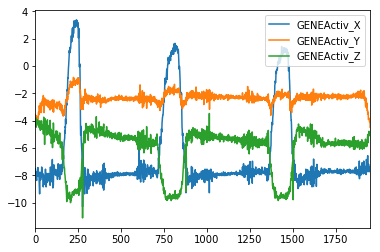

In [24]:
rawdata.iloc[:,1:4].plot()

In [25]:
rawdata.head()

,timestamp,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude
0,1.434973e+09,-7.51189,-3.56766,-4.28453,9.35489
1,1.434973e+09,-7.55112,-3.95894,-4.05407,9.44077
2,1.434973e+09,-7.86689,-4.15409,-3.78537,9.66817
3,1.434973e+09,-7.86690,-4.27178,-4.13055,9.85889
4,1.434973e+09,-7.90612,-3.88050,-4.36101,9.82769


## TSNE Test

In [953]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

In [1023]:
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
le = preprocessing.LabelEncoder()
df_copy = df_train.copy()
cat_cols = ['device', 'session', 'site', 'task', 'visit', 'deviceSide']
for c in cat_cols:
    df_copy[c]=le.fit_transform(df_train[c])

In [957]:
df_train = df_copy

In [975]:
c = 0
Dur = []
for f in df_train.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)
df_train['duration'] = Dur

In [ ]:
row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
Scores = []
Subjs = []
DataFiles = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    metadata = pd.to_numeric(df_train.iloc[i,:][['device', 'session', 'site', 'task', 'visit', 'deviceSide', 'duration']]).values
    score = df_train.iloc[i,:].bradykinesiaScore
    subj = df_train.iloc[i,:].patient
    dfile = df_train.iloc[i,:].dataFileHandleId
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,clipsize=5,overlap=0.5) #take clips
            for clip in clips:
                F,flist = feature_extraction(clip)
                F = np.append(metadata,F)
                F = np.reshape(F,(1,-1))
                Features.append(F) #the features from all the clips
                Scores.append(score)
                Subjs.append(subj)
                DataFiles.append(dfile)
        except(TypeError):
            print('found incompatible datatype')
            
    else:
        F = np.empty((1,len(flist)+7)) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

tempFeatures = Features

Features = tempFeatures
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

NAFeat = pd.DataFrame(Features).dropna()
SVMScores = pd.DataFrame(np.zeros((len(NAFeat.iloc[:,1]),1)))
Scores = np.array(Scores)

logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X = NAFeat, groups = Subjs):

    print(np.unique(np.array(Subjs)[test_index]))
    
    # Filter Data and remove Nans
    Train = pd.DataFrame(NAFeat.values[train_index,:])
    Test = pd.DataFrame(NAFeat.values[test_index,:])
    
    TrainScores = Scores[train_index]
    TestScores = Scores[test_index]

    scaler = StandardScaler()
    Train.iloc[:,6:]=scaler.fit_transform(Train.iloc[:,6:])
    Test.iloc[:,6:]=scaler.transform(Test.iloc[:,6:])
    
    ZScoreID = TrainScores==0
    
    svc = OneClassSVM(kernel='rbf', nu=.5)
    svc.fit(Train.values[ZScoreID,:])
        
    SVMScores.values[test_index] = svc.decision_function(Test.values)

DataFiles = pd.Series(DataFiles)
IDs = pd.DataFrame(df_train.dataFileHandleId)
SVMScoreMax = []
SVMScoreMin = []
SVMScoreMedian = []
SVMScore75 = []
SVMScore25 = []
SVMScoreMean = []
SVMScoreStd = []
for row in IDs.itertuples():
    index = DataFiles == row[1]
    if not any(index):
        continue
    SVMScoreMax.append(np.max(SVMScores[index]))
    SVMScoreMin.append(np.min(SVMScores[index]))
    SVMScoreMedian.append(np.median(SVMScores[index]))
    SVMScore75.append(np.percentile(SVMScores[index],75))
    SVMScore25.append(np.percentile(SVMScores[index],25))
    SVMScoreMean.append(np.mean(SVMScores[index]))
    SVMScoreStd.append(np.std(SVMScores[index]))

In [1068]:
len(SVMScoreMax)

2913

In [1031]:
train_index.shape

(31649,)

In [984]:
NAFeat.iloc[:,6:]

,6,7,8,9,10,11,12,13,14,15,...,23,24,25,26,27,28,29,30,31,32
0,38.98,42.532257,13.911501,23.372372,2.849767,1.305419,2.155053,0.004620,-0.011679,0.013896,...,0.104807,1.831661,19.861196,0.227572,0.208196,0.492000,0.412000,0.440000,6.200000,0.086405
1,38.98,110.549702,13.428940,44.716383,6.508088,1.816240,5.411489,-0.004373,0.002757,0.004113,...,2.112350,42.342214,0.236613,0.719630,0.376214,0.500000,0.364000,0.428000,1.600000,0.088687
2,38.98,94.901370,9.642405,39.146328,6.508088,1.816240,5.411489,-0.017204,-0.001585,-0.007738,...,5.618544,55.162070,3.331870,1.405428,17.940271,0.508000,0.548000,0.428000,9.800000,0.084778
3,38.98,15.039845,5.043884,10.746713,2.789979,1.642226,1.422582,-0.000416,-0.000330,0.003041,...,12.783654,2.421091,215.160534,12.147197,11.590716,0.480000,0.500000,0.508000,6.200000,0.087498
4,38.98,18.492317,7.841640,20.485443,2.603372,1.646238,2.003269,-0.010427,-0.005886,0.001090,...,5.489959,1.747202,1.037367,8.560063,2.363235,0.428000,0.500000,0.508000,8.800000,0.089254
5,38.98,31.424712,8.689695,19.033995,2.163422,1.152701,2.003269,-0.002787,-0.005777,-0.004359,...,0.529985,1.629552,0.137425,0.667897,0.194054,0.360000,0.480000,0.960000,5.200000,0.077481
6,38.98,34.358845,9.181088,24.752918,2.882658,1.210264,3.964270,0.010685,0.004867,-0.003210,...,0.415029,38.849453,0.792747,7.549958,1.019843,0.400000,0.476000,0.504000,7.000000,0.079426
7,38.98,18.842394,8.262384,25.503490,2.799623,1.518248,4.756950,0.003319,0.006528,-0.000119,...,3.424705,38.947220,17.589705,5.435325,9.950614,0.492000,0.512000,0.508000,9.400000,0.116834
8,38.98,9.140384,6.426268,13.357765,1.902807,1.783929,2.519205,-0.001165,0.000570,0.001771,...,7.850574,10.039867,2.802374,8.868845,6.563489,0.496000,0.500000,0.504000,3.400000,0.066793
9,38.98,17.219731,6.943192,18.792695,1.836577,1.635411,2.233341,-0.020116,-0.004896,0.013615,...,5.614919,3.234242,0.643071,0.719981,0.839278,0.440000,0.500000,0.556000,5.200000,0.132828


In [974]:
pd.DataFrame(Features)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,42.532257,13.911501,23.372372,...,0.104807,1.831661,19.861196,0.227572,0.208196,0.492000,0.412000,0.440000,6.200000,0.086405
1,0.0,0.0,0.0,0.0,0.0,1.0,NaN,110.549702,13.428940,44.716383,...,2.112350,42.342214,0.236613,0.719630,0.376214,0.500000,0.364000,0.428000,1.600000,0.088687
2,0.0,0.0,0.0,0.0,0.0,1.0,NaN,94.901370,9.642405,39.146328,...,5.618544,55.162070,3.331870,1.405428,17.940271,0.508000,0.548000,0.428000,9.800000,0.084778
3,0.0,0.0,0.0,0.0,0.0,1.0,NaN,15.039845,5.043884,10.746713,...,12.783654,2.421091,215.160534,12.147197,11.590716,0.480000,0.500000,0.508000,6.200000,0.087498
4,0.0,0.0,0.0,0.0,0.0,1.0,NaN,18.492317,7.841640,20.485443,...,5.489959,1.747202,1.037367,8.560063,2.363235,0.428000,0.500000,0.508000,8.800000,0.089254
5,0.0,0.0,0.0,0.0,0.0,1.0,NaN,31.424712,8.689695,19.033995,...,0.529985,1.629552,0.137425,0.667897,0.194054,0.360000,0.480000,0.960000,5.200000,0.077481
6,0.0,0.0,0.0,0.0,0.0,1.0,NaN,34.358845,9.181088,24.752918,...,0.415029,38.849453,0.792747,7.549958,1.019843,0.400000,0.476000,0.504000,7.000000,0.079426
7,0.0,0.0,0.0,0.0,0.0,1.0,NaN,18.842394,8.262384,25.503490,...,3.424705,38.947220,17.589705,5.435325,9.950614,0.492000,0.512000,0.508000,9.400000,0.116834
8,0.0,0.0,0.0,0.0,0.0,1.0,NaN,9.140384,6.426268,13.357765,...,7.850574,10.039867,2.802374,8.868845,6.563489,0.496000,0.500000,0.504000,3.400000,0.066793
9,0.0,0.0,0.0,0.0,0.0,1.0,NaN,17.219731,6.943192,18.792695,...,5.614919,3.234242,0.643071,0.719981,0.839278,0.440000,0.500000,0.556000,5.200000,0.132828


In [938]:
svc = OneClassSVM(kernel='rbf', nu=.5)
svc.fit(NAFeat.values[ZScoreID,:])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [939]:
SVMScores = svc.decision_function(NAFeat.values)

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


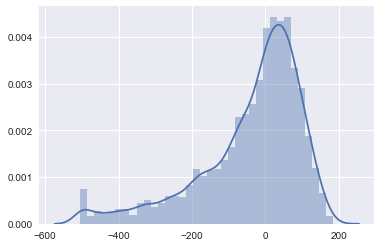

In [940]:
seaborn.distplot(SVMScores[ZScoreID])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


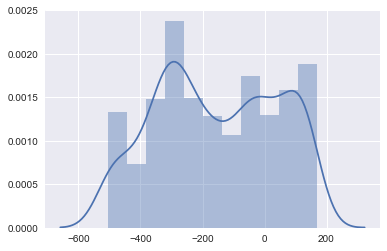

In [941]:
seaborn.distplot(SVMScores[PScoreID])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


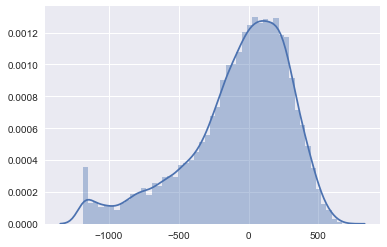

In [387]:
seaborn.distplot(SVMScores[ZScoreID]) # 5s 0 overlap

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


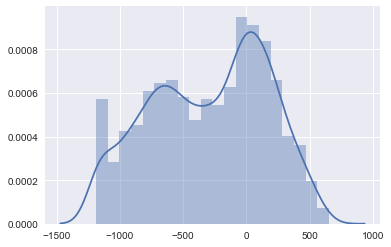

In [388]:
seaborn.distplot(SVMScores[PScoreID])

In [348]:
pca = PCA()
PCAFeat = pca.fit_transform(NAFeat)
pca.explained_variance_ratio_

array([ 0.20830241,  0.10361602,  0.07088906,  0.05306095,  0.04583389,
        0.045196  ,  0.04420307,  0.04335738,  0.03934392,  0.03884013,
        0.03843778,  0.03817775,  0.03647873,  0.03226223,  0.02843997,
        0.02657754,  0.02524965,  0.02452012,  0.01774712,  0.01396395,
        0.01303582,  0.00498674,  0.0032165 ,  0.00248041,  0.00117088,
        0.00061199])

In [350]:
pca.fit(NAFeat.values[ZScoreID,:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [351]:
PCAFeat = pca.transform(NAFeat.loc[:,:])
M = np.mean(PCAFeat[ZScoreID,:],axis=0)
S = np.std(PCAFeat[ZScoreID,:],axis=0)

In [357]:
A = np.array([np.max(np.abs((row-M)/S)[:]) for row in PCAFeat])
B = np.array([np.sum(np.abs((row-M)/S)[:]) for row in PCAFeat])
C = np.array([np.median(np.abs((row-M)/S)[:]) for row in PCAFeat])
D = np.array([np.percentile(np.abs((row-M)/S)[:],25) for row in PCAFeat])
E = np.array([np.linalg.norm(np.abs((row-M)/S)[:]) for row in PCAFeat])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


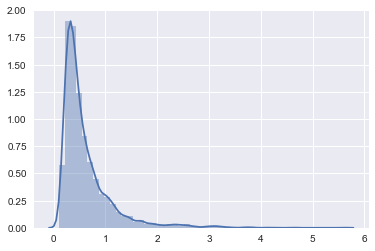

In [358]:
ax = seaborn.distplot(C[PScoreID])
# ax.axes.set_xlim([0,5])
# ax.axes.set_ylim([0,2.75])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


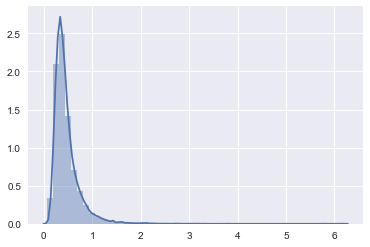

In [359]:
ax = seaborn.distplot(C[ZScoreID])
# ax.axes.set_xlim([0,5])
# ax.axes.set_ylim([0,2.75])

In [196]:
PCAComp = pd.DataFrame(PCAFeat[:,0:2])
PCAComp.columns = ['X', 'Y']
PCAComp['Scores'] = pd.Series(Scores)

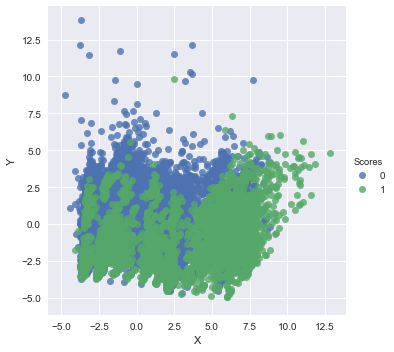

In [197]:
seaborn.lmplot('X','Y',data = PCAComp, hue = 'Scores', fit_reg=False)

In [365]:
X_embedded = TSNE(n_components=2, perplexity=150, init='random').fit_transform(PCAFeat)

In [366]:
Embed = pd.DataFrame(X_embedded)
Embed.columns = ['X', 'Y']
Embed['Scores'] = pd.Series(Scores)

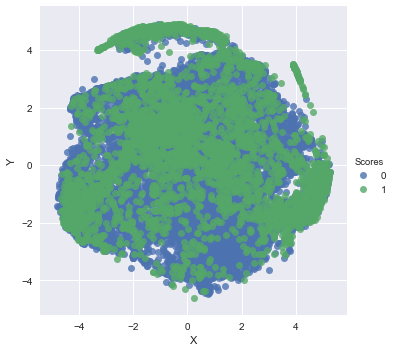

In [367]:
seaborn.lmplot('X','Y',data = Embed, hue = 'Scores', fit_reg=False)

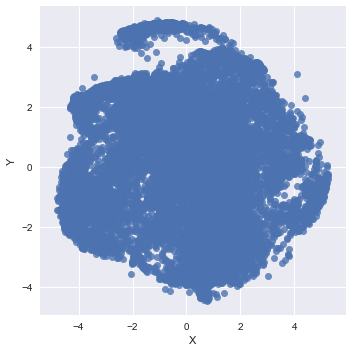

In [368]:
seaborn.lmplot('X','Y',data = Embed[Embed['Scores']==0], fit_reg=False)

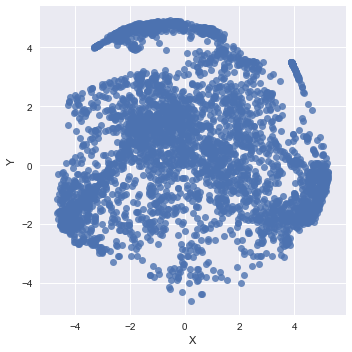

In [369]:
seaborn.lmplot('X','Y',data = Embed[Embed['Scores']==1], fit_reg=False)

In [956]:
df_train = df_copy

In [1004]:
row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
Scores = []
SVMScores = []; MeanScores = []; MedScores = []; StdScores = []; MaxScores = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    metadata = pd.to_numeric(df_train.iloc[i,:][['device', 'session', 'site', 'task', 'visit', 'deviceSide', 'duration']]).values
    score = df_train.iloc[i,:].bradykinesiaScore
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,clipsize=5,overlap=0.5) #take clips
            maxScore = 10000;
            SVMScores = []
            FtempList = []
            for clip in clips:
                Ftemp,flist = feature_extraction(clip)
                FtempList.append(Ftemp)
                Ftemp2 = np.reshape(np.append(metadata,Ftemp),(1,-1))
                Ftemp2[:,6:] = Scalers[int(metadata[1])].transform(Ftemp2[:,6:])
#                 PCAScore = np.median(np.abs((pca.transform(Ftemp2)-M)/S))
                Ftemp2 = np.reshape(Ftemp2,(1,-1))
                SVMScore = SVMs[int(metadata[1])].decision_function(Ftemp2)
                SVMScores.append(SVMScore)
                if SVMScore<maxScore:
                    maxScore = SVMScore
                    F = Ftemp
#             windowInd = np.argmin(np.array(SVMScores)-np.percentile(SVMScores,10))
#             F = FtempList[windowInd]
#             F = np.reshape(np.append(metadata,F),(1,-1))
            Features.append(F) #the features from all the clips
            Scores.append(score)
            MaxScores.append(maxScore)
            MeanScores.append(np.mean(SVMScores))
            MedScores.append(np.percentile(SVMScores,50))
            SVMScores.append(np.percentile(SVMScores,10))
            StdScores.append(np.std(SVMScores))
            #stack mean and std over clips
#             flist = flist+['s_'+n for n in flist] #update feature list w std
#             Fmean = np.mean(Fclips,axis=0)
#             Fstd = np.std(Fclips,axis=0)
#             F = np.hstack((Fmean,Fstd))
#             if F.size != 52:
#                 print(F.shape)
#                 sys.exit()
#             Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
            
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 217.3
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


In [1013]:
MaxScores = np.squeeze(np.array(MaxScores),axis=1)

In [1014]:
DistMetric = pd.DataFrame(MaxScores1)
# DistMetric = pd.DataFrame(np.squeeze(np.array(PCAScores),axis=1))
DistMetric.columns = ['PCAScore']
DistMetric['TrueScore'] = pd.Series(Scores)

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


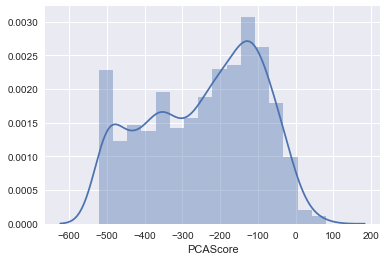

In [1015]:
seaborn.distplot(DistMetric[DistMetric.TrueScore==0].PCAScore)

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


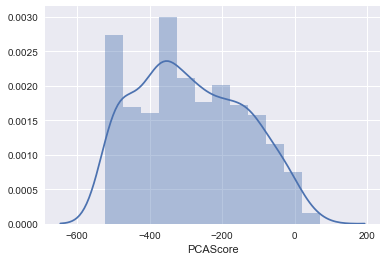

In [1016]:
seaborn.distplot(DistMetric[DistMetric.TrueScore==1].PCAScore)

In [1017]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)
# NAFeat = pd.DataFrame(Features).dropna()

# scaler = StandardScaler()
# NAFeat.iloc[:,6:]=scaler.fit_transform(NAFeat.iloc[:,6:])

(3016, 26)


In [1018]:
df_train2 = df_train
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat['SVMScoreMean'] =pd.Series(MeanScores)
df_feat['SVMScoreMed'] =pd.Series(MedScores)
df_feat['SVMScoreStd'] =pd.Series(StdScores)
df_feat.index = df_train2.index
df_train2 = pd.concat((df_train2,df_feat),axis=1)
df_train2 = df_train2.drop(['tremorScore', 'dyskinesiaScore', 'bradykinesiaScore', 'path'], axis=1)
df_train2 = df_train2.dropna()
scaler2 = StandardScaler()
df_train2.iloc[:,8:]=scaler2.fit_transform(df_train2.iloc[:,8:])

In [1019]:
df_train2.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,duration,EX,...,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel,SVMScoreMean,SVMScoreMed,SVMScoreStd
25819_22,17286028,0,13_BOS,0,0,0,0,1,1.015733,-0.240117,...,-0.085822,-0.012916,0.079278,0.268402,-0.330992,2.522832,-0.975417,-0.470470,-0.555937,0.545739
25820_22,17286030,1,13_BOS,0,0,0,0,0,1.015733,-0.226627,...,-0.087675,-0.084300,-2.065593,0.760626,-0.117273,-0.985594,1.240590,0.544855,0.548516,-0.499788
25821_22,17286034,0,13_BOS,0,0,1,0,1,6.658398,-0.255094,...,-0.083970,-0.075810,0.079278,0.032134,-2.332181,2.196466,-0.940609,-0.251597,-0.341486,-0.924349
25822_22,17286036,1,13_BOS,0,0,1,0,0,6.658398,-0.247545,...,-0.086868,-0.078596,2.319902,2.020718,-0.000699,-0.985594,-0.945564,-0.135710,-0.246789,-0.975691
25824_22,17286042,1,13_BOS,0,0,2,0,0,-0.865156,-0.259760,...,-0.090069,-0.085208,-1.203814,-0.263200,1.281616,-0.659229,1.753780,0.688743,0.558053,-0.368219


In [1020]:
df_train2.to_csv('SVMTest.csv')

In [1021]:
%run sc2FitModels_LOSOCV.py bradykinesia SVMTest.csv

Welcome, Nicholas Shawen!

AUPRC: 0.878


In [320]:
NAFeat = pd.DataFrame(Features).dropna()
scaler.fit_transform(NAFeat).shape

(2913, 26)

In [327]:
np.max(PCAScores)

6.1904437715432277

In [660]:
X_embedded = TSNE(n_components=2, perplexity=500, init='pca').fit_transform(df_train2.drop(['dataFileHandleId', 'patient'], axis=1))

In [661]:
Embed = pd.DataFrame(X_embedded)
Embed.columns = ['X', 'Y']
Embed['Scores'] = pd.Series(Scores)

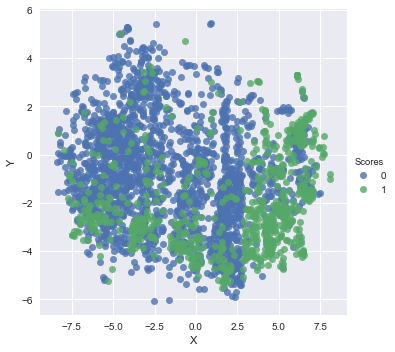

In [662]:
seaborn.lmplot('X','Y',data = Embed, hue = 'Scores', fit_reg=False)

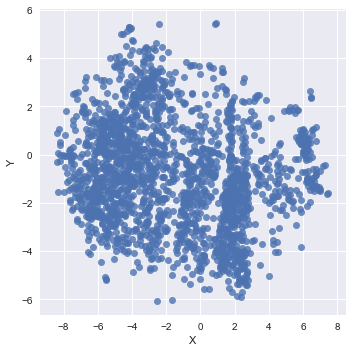

In [663]:
seaborn.lmplot('X','Y',data = Embed[Embed['Scores']==0], fit_reg=False)

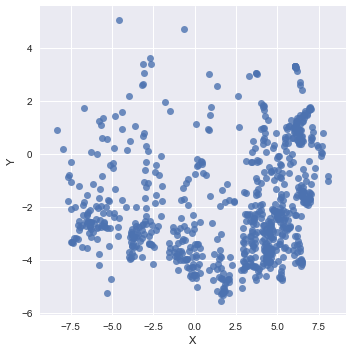

In [664]:
seaborn.lmplot('X','Y',data = Embed[Embed['Scores']==1], fit_reg=False)